In [3]:
# !pip install tensorflow

# **Import necessary libraries**

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## **Load Datasets**

In [5]:
# Load triplets data from a CSV file (replace 'triplets.csv' with your file)
triplets_df = pd.read_csv(r"D:/Datasets/Image_data/CelebA FR Triplets/triplets.csv")
image_path = r"D:/Datasets/Image_data/CelebA FR Triplets/images/"

# **Load and Preprocess dataset**

In [6]:
# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (118, 118))
    img = tf.cast(img, tf.float32) / 255.0
    return img

# **Split train and test data portion**

In [7]:
# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(triplets_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# **Create Data Generator**

In [8]:
# Define a custom data generator
class TripletDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, image_directory, batch_size=32, shuffle=True):
        self.df = df
        self.image_directory = image_directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        anchor_images, positive_images, negative_images = [], [], []
        for i in batch_indexes:
            anchor_img = load_and_preprocess_image(os.path.join(self.image_directory, self.df.iloc[i]['anchor']))
            pos_img = load_and_preprocess_image(os.path.join(self.image_directory, self.df.iloc[i]['pos']))
            neg_img = load_and_preprocess_image(os.path.join(self.image_directory, self.df.iloc[i]['neg']))
            anchor_images.append(anchor_img)
            positive_images.append(pos_img)
            negative_images.append(neg_img)
        return [np.array(anchor_images), np.array(positive_images), np.array(negative_images)], np.zeros((len(batch_indexes),))

## **Create data generator**

In [9]:
# Create data generators for training, validation, and test sets
batch_size = 72
train_data_generator = TripletDataGenerator(train_df, image_path, batch_size=batch_size)
val_data_generator = TripletDataGenerator(val_df, image_path, batch_size=batch_size)
test_data_generator = TripletDataGenerator(test_df, image_path, batch_size=batch_size, shuffle=False)

## **Define CNN Siamese network model**

In [10]:
# Define the Siamese network model
def create_siamese_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(256)(x)
    return keras.Model(inputs=input_layer, outputs=output_layer)

## **Create Siamese submodels**

In [11]:
# Create Siamese submodels
input_shape = (118, 118, 3)
siamese_model = create_siamese_model(input_shape)
input_anchor = layers.Input(shape=input_shape)
input_positive = layers.Input(shape=input_shape)
input_negative = layers.Input(shape=input_shape)
encoded_anchor = siamese_model(input_anchor)
encoded_positive = siamese_model(input_positive)
encoded_negative = siamese_model(input_negative)

# **Define Triplet Loss**

In [12]:
# Define the triplet loss
margin = 0.2
positive_dist = tf.reduce_sum(tf.square(encoded_anchor - encoded_positive), axis=-1)
negative_dist = tf.reduce_sum(tf.square(encoded_anchor - encoded_negative), axis=-1)
triplet_loss = tf.maximum(0.0, positive_dist - negative_dist + margin)

# **Create and compile the Siamese network model**

In [13]:
# Create and compile the Siamese network model
siamese_net = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=triplet_loss)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.000001)
siamese_net.compile(optimizer=custom_optimizer, loss=lambda y_true, y_pred: y_pred)

# **Implement callback threshhold**

In [22]:
class LossThresholdCallback(Callback):
    def __init__(self, threshold):
        super(LossThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        siamese_net.save("D:/Datasets/Image_data/CelebA FR Triplets/images/face_verification_siamese_model.h5")
        if logs is None:
            logs = {}

        current_loss = logs.get('loss')
        if current_loss is not None and current_loss < self.threshold:
            print(f"\nReached loss threshold of {self.threshold}. Stopping training.")
            self.model.stop_training = True
# Train the model as before
threshold_callback = LossThresholdCallback(threshold=0.000000001)

# **Train the model**

In [ ]:
# Train the Siamese network
num_epochs = 100
history = siamese_net.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=num_epochs,
    callbacks=[threshold_callback]
)

Epoch 1/100
182/182 [==============================] - 1028s 6s/step - loss: 110.2491 - val_loss: 14.5532
Epoch 2/100
182/182 [==============================] - 840s 5s/step - loss: 59.6193 - val_loss: 17.4606
Epoch 3/100
182/182 [==============================] - 842s 5s/step - loss: 43.5322 - val_loss: 14.1494
Epoch 4/100
182/182 [==============================] - 841s 5s/step - loss: 37.0465 - val_loss: 12.2918
Epoch 5/100
182/182 [==============================] - 840s 5s/step - loss: 32.6453 - val_loss: 11.0410
Epoch 6/100
182/182 [==============================] - 866s 5s/step - loss: 28.8803 - val_loss: 10.1259
Epoch 7/100
182/182 [==============================] - 874s 5s/step - loss: 25.6092 - val_loss: 9.1869
Epoch 8/100
182/182 [==============================] - 850s 5s/step - loss: 22.8828 - val_loss: 8.5861
Epoch 9/100
182/182 [==============================] - 849s 5s/step - loss: 21.1690 - val_loss: 8.0504
Epoch 10/100
182/182 [==============================] - 851s 5s/s

# summary of the model's architecture

In [15]:
# Print a summary of the model's architecture
siamese_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 118, 118, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 118, 118, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 118, 118, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256)                  2584172   ['input_2[0][0]',             
                                                          8          'input_3[0][0]',       

# Ploting the model

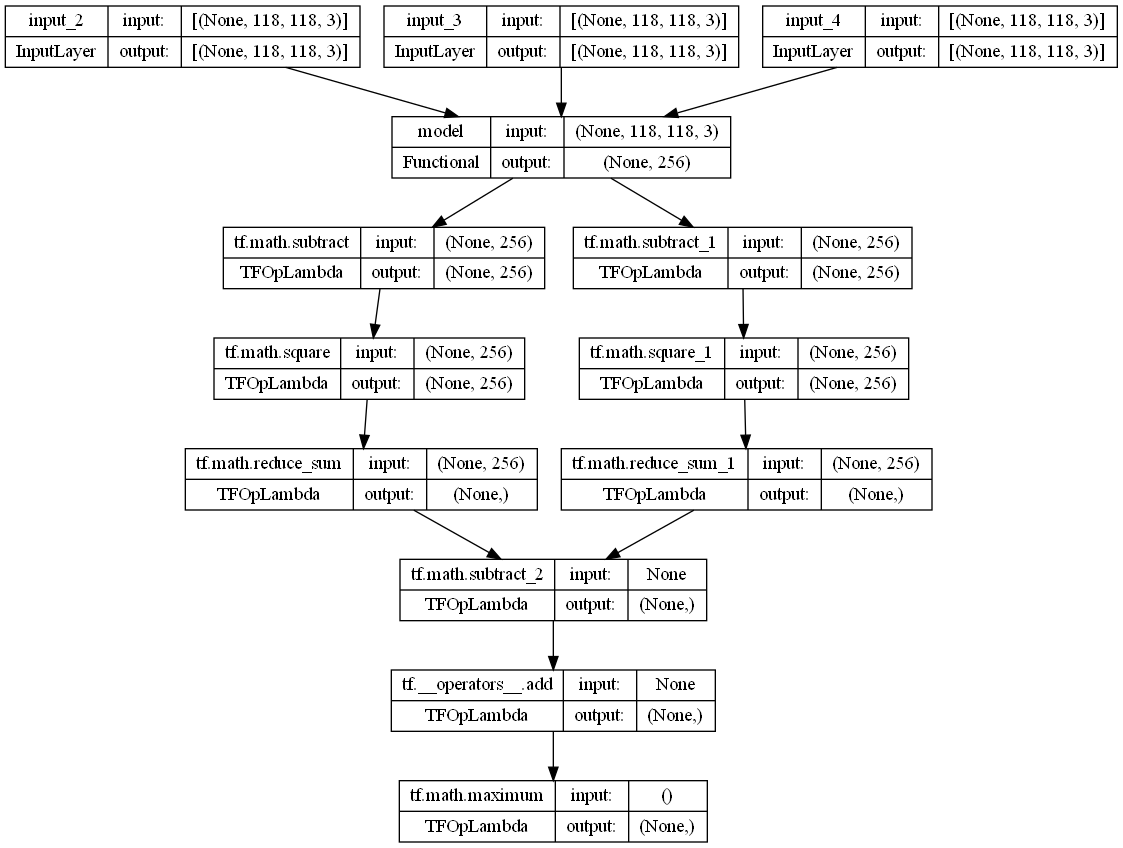

In [16]:

# Specify the file path where you want to save the plot
plot_path = 'siamese_net_plot.png'

# Visualize the model architecture and save it to a file
plot_model(siamese_net, to_file=plot_path, show_shapes=True, show_layer_names=True)

# Display the visualization in Jupyter Notebook (optional)
from IPython.display import Image
Image(filename='siamese_net_plot.png')


# Plot training & validation loss values

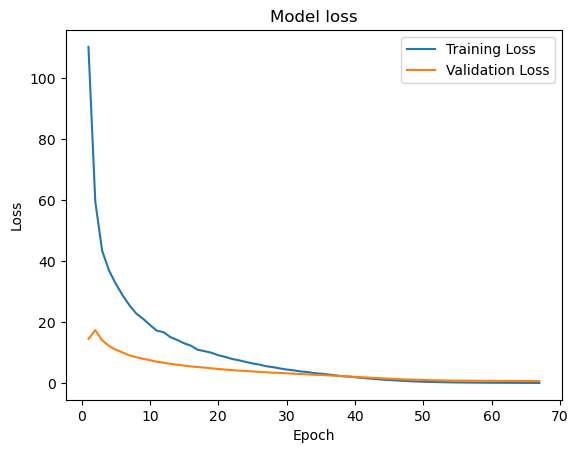

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Save the model

In [ ]:
modelfilepath = r"D:/Datasets/Image_data/CelebA FR Triplets/images/"
siamese_net.save("D:/Datasets/Image_data/CelebA FR Triplets/images/face_verification_siamese_model.h5")
tf.keras.models.save_model(
    siamese_net,
    modelfilepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)